In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

from lightkurve import search_lightcurvefile
from altaipony.flarelc import FlareLightCurve
from altaipony.fakeflares import aflare

import os
import copy

import numpy as np
import pandas as pd

#from funcs.custom_detrending import custom_detrending, iteratively_remove_sines
from funcs.helper import read_custom_aperture_lc
from funcs.multiperiod import find_period, fetch_lightcurve, remove_sinusoidal

from altaipony.lcio import from_path, from_mast

#import astropy.units as u

from scipy import optimize
from scipy.misc import derivative

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest

In [3]:
sectors = {44984200: [8, 9, 10]}

In [3]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,tlumerr,kflux,kfluxerr,klum,klumerr,gmag,jmag,kmag,i_mu,i_sigma
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,6.553810e+27,6.712990e-13,4.272880e-14,2.263849e+28,1.444680e+27,17.8356,13.078,11.771,0.859459,0.080231
1,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,5.645140e+29,1.272670e-11,6.844750e-13,3.232358e+30,1.750110e+29,14.9796,11.530,10.636,0.371856,0.040246
2,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,6.480260e+28,2.018160e-11,1.412120e-12,2.979395e+29,2.089910e+28,14.4115,10.309,9.268,0.578452,0.028256
3,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,1.051740e+29,1.380730e-11,1.517240e-12,3.103479e+29,3.444490e+28,14.7381,10.630,9.666,1.520214,0.041615
4,230120143,16,slc,2,tess,TIC,generic,TESS,M7,1741.00,...,3.430260e+29,4.102720e-11,4.508350e-12,1.023014e+30,1.126940e+29,13.5557,9.854,8.950,0.419312,0.017265


In [8]:
target = lcs.loc[0]
target


ID                             100004076
QCS                                   14
typ                                  slc
cadence_min                            1
mission                              kep
prefix                               KIC
origin                           generic
h_mission                         Kepler
SpT                                   L1
view_start                        1356.5
view_stop                           1361
view_min                             600
view_max                            1050
BJDoff                           2454833
tstart                           1358.55
ampl_min                             NaN
ampl_max                             NaN
GRP                                  NaN
plxmas                               NaN
eplxmas                              NaN
RA                                 286.7
Dec                              40.1857
J                                 13.078
R                                    NaN
Gaia_G          

In [15]:
flcks = search_lightcurvefile(f"{target.prefix} {target.ID}", cadence="short", quarter=14)
flcks

#,observation,target_name,productFilename,distance
0,Kepler Quarter 14,kplr100004076,kplr100004076-2012211050319_slc.fits,0.0
1,Kepler Quarter 14,kplr100004076,kplr100004076-2012242122129_slc.fits,0.0
2,Kepler Quarter 14,kplr100004076,kplr100004076-2012277125453_slc.fits,0.0


In [20]:
l = [3,4,2]
list(l)

[3, 4, 2]

In [11]:
flcs= flcks.download_all()

Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/Kepler/kplr100004076_sc_Q000000000000003000/kplr100004076-2012211050319_slc.fits with expected size 4561920.
19% (8480/45330) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
19% (8480/45330) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/Kepler/kplr100004076_sc_Q000000000000003000/kplr100004076-2012242122129_slc.fits with expected size 4458240.
0% (106/44280) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (106/44280) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/Kepler/kplr100004076_sc_Q000000000000003000/kplr100004076-2012277125453_slc.fits with expected size 5045760.
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bi

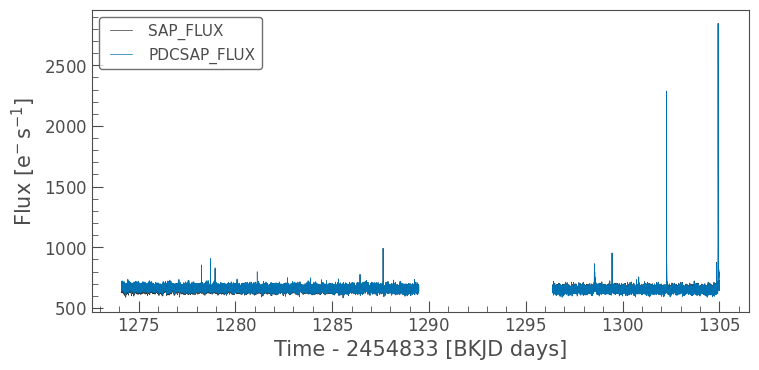

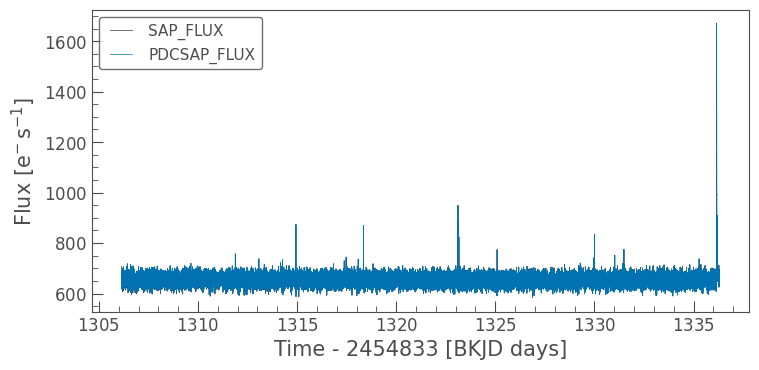

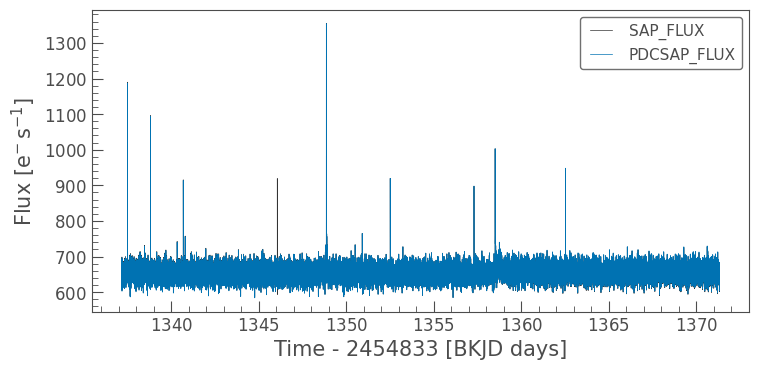

In [14]:
for flc in flcs:
    flc.plot()

In [6]:
def custom_detrend(flc):
    t, sflux, model, period = remove_sinusoidal(target, save=False, flc=flc, plot=False, custom=False)
    f = FlareLightCurve(time = t.byteswap().newbyteorder(), 
                        flux = flc.flux,
                        detrended_flux=sflux.byteswap().newbyteorder(), 
                        detrended_flux_err=flc.flux_err.byteswap().newbyteorder())
    f = f[np.isfinite(f.detrended_flux)]
    return f


In [16]:
flc = from_mast(f"{target.prefix} {target.ID}", cadence="short", c=14, mission="Kepler")

Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/Kepler/kplr100004076_sc_Q000000000000003000/kplr100004076-2012211050319_slc.fits with expected size 4561920.
19% (8480/45330) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
19% (8480/45330) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


In [11]:
df = pd.DataFrame()


Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019032160000-s0008-0000000044984200-0136-s/tess2019032160000-s0008-0000000044984200-0136-s_lc.fits with expected size 1805760.
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 44984200 modulation period:  2.7118420429208214 h
Relative amplitude of modulation: 7.7e-03


Found 0 candidate(s) in the (0,8399) gap.
Found 1 candidate(s) in the (8399,13420) gap.


TIC 44984200 modulation period:  2.7118420429208214 h
Relative amplitude of modulation: 7.7e-03


Found 0 candidate(s) in the (0,8399) gap.
Found 1 candidate(s) in the (8399,13420) gap.
N/A%|                                                                         |
Detrending fake LC:



TIC 44984200 modulation period:  2.7118420429208214 h
Relative amplitude of modulation: 7.7e-03


Found 1 candidate(s) in the (0,8399) gap.
Found 1 candidate(s) in the (8399,13420) gap.
100%|#########################################################################|
The file is appended to an existing table.


Before loading extra events:  2
After loading extra events:  982
10


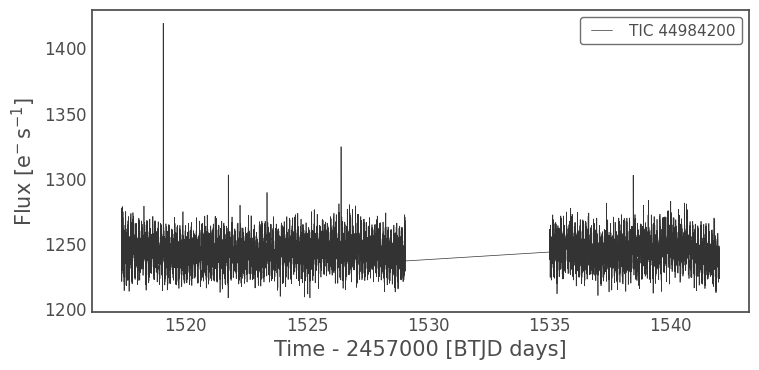

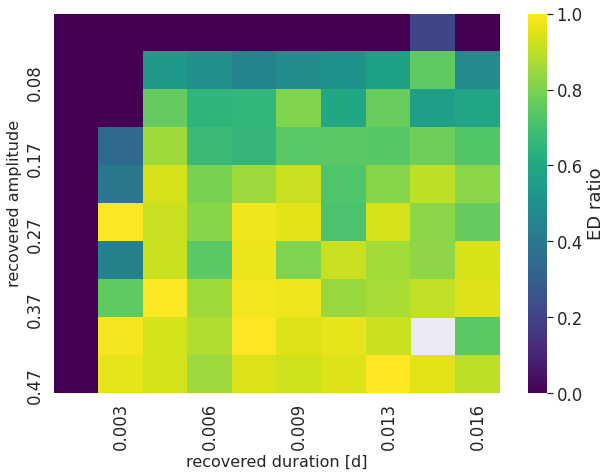

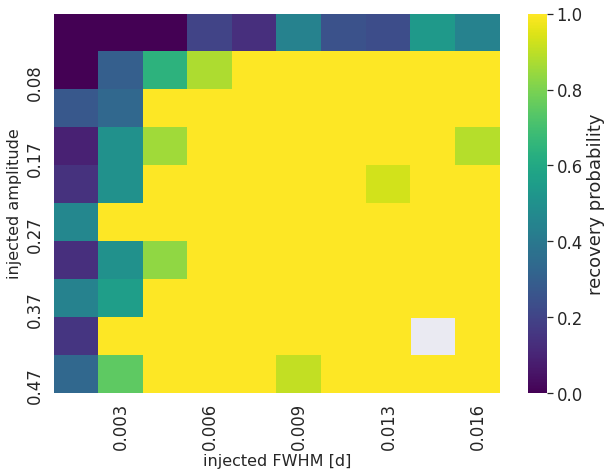

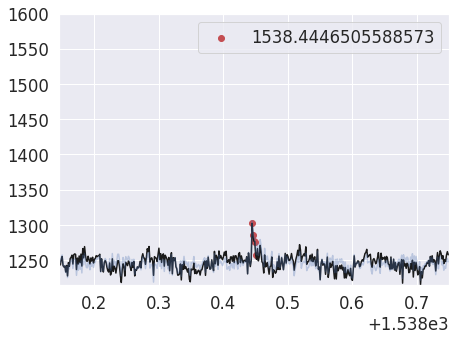

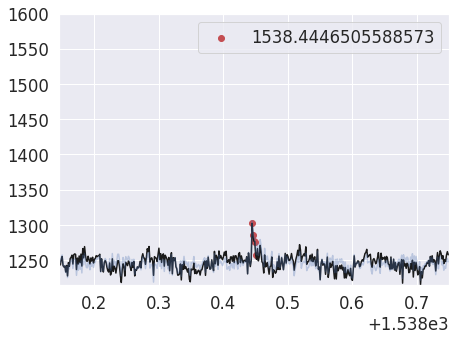

In [14]:
for sec in [8]:#sectors[target.ID]:

    flc = from_mast(f"{target.prefix} {target.ID}", cadence="short", c=sec, mission="TESS")
    
    flc.plot()
    f = custom_detrend(flc)

    flares = f.find_flares().flares
    flares["ID"] = target.ID
    flares["sector"] = sec
    df = df.append(flares)
    
    # Inj/Rec
    df["dur"] = df.tstop - df.tstart
    flc, fake_flc = flc.sample_flare_recovery(inject_before_detrending=True, mode="custom",
                                              iterations=10, fakefreq=1e-3, 
                                              ampl=[df.ampl_rec.min()/2, df.ampl_rec.max()*1.5],
                                              dur=[df.dur.min()/6., df.dur.max()/4.], 
                                              func=custom_detrend)
    with open(f"{CWD}/analysis/results/flarefind/{target.ID}_s{sec}_fake_flares.csv", "a") as F:
        flc.fake_flares.to_csv(F, index=False)
        
    print("Before loading extra events: ", flc.fake_flares.shape[0])
    flc.load_injrec_data(f"{CWD}/analysis/results/flarefind/{target.ID}_s{sec}_fake_flares.csv")
    flc.fake_flares = flc.fake_flares.drop_duplicates(keep=False).astype(float)
    print("After loading extra events: ", flc.fake_flares.shape[0])
    
    # Characterize flares
    flc.flares = df
    
    density = 10
    flc = flc.characterize_flares(flares_per_bin=density)

    flc.plot_ed_ratio_heatmap(flares_per_bin=density)
    
    flc.plot_recovery_probability_heatmap(flares_per_bin=density)

    # View flares
    subdf = df[(df.sector==sec) & (df.ID==target.ID)]
    
    for i, r in subdf.iterrows():
        plt.figure(figsize=(7,5))
        plt.plot(flc.time, flc.flux,c="k")
        plt.plot(f.time, f.detrended_flux,c="b", alpha=.3)
        sta, sto = int(r.istart), int(r.istop)+1
        plt.scatter(flc.time[sta:sto], flc.flux[sta:sto], c="r", label=r.tstart)#, label=f"EPIC {EPIC}, C{C}")#
        plt.xlim(r.tstart-.3,r.tstop+.3)
        plt.ylim(np.nanmin(1.*f.detrended_flux),1600)#1.*np.nanmax(f.detrended_flux))
       
        plt.legend()


In [10]:
with open(f"{CWD}/analysis/results/flarefind/all_flares.csv", "a") as f:
    flc.flares.to_csv(f, index=False)

In [15]:
flc.flares.T

,0,1,2,3
istart,10867,10867,10867,10867
istop,10871,10871,10871,10871
cstart,NaN,NaN,NaN,NaN
cstop,NaN,NaN,NaN,NaN
tstart,1538.44,1538.44,1538.44,1538.44
tstop,1538.45,1538.45,1538.45,1538.45
ed_rec,17.6233,17.6233,17.6233,17.6233
ed_rec_err,2.06521,2.06521,2.06521,2.06521
ampl_rec,0.0496053,0.0496053,0.0496053,0.0496053
total_n_valid_data_points,13420,13420,13420,13420


In [ ]:
df["obst"] = obst/30#in hours
df = df[(df.tstart<target.tstart-.1) | (df.tstart>target.tstart+1)]
df

In [ ]:
df.to_csv(f"{CWD}/analysis/results/flarefind/{target.ID}_all_flares_short_cadence.csv", index=False)

In [ ]:
1214/24

In [ ]:
plt.scatter(df.tstop-df.tstart, df.ampl_rec)
plt.scatter([0.74424276547], [1.5470349624552])
plt.yscale("log")
plt.xscale("log")
plt.ylim(.05,2)
plt.xlim(5e-3,1)
plt.xlabel("time [d ]")
plt.ylabel("rel. amplitude")
plt.savefig(f"{CWD}/analysis/results/flarefind/{target.ID}_all_flares_short_cadence.png", dpi=300)

In [ ]:
paths = !ls  /work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/flarefind/100004076_all_flares_short_cadence.csv
paths

In [ ]:
df = pd.DataFrame()
for p in paths:
    df = df.append(pd.read_csv(p))

In [ ]:
df

In [ ]:
plt.scatter(df.tstop-df.tstart, df.ampl_rec)
plt.scatter([0.25],[.46])
plt.yscale("log")
plt.xscale("log")
plt.ylim(.05,20)
plt.xlim(5e-3,6)
plt.xlabel("time [d ]")
plt.ylabel("rel. amplitude")
#plt.savefig(f"{CWD}/analysis/results/flarefind/all_flares_short_cadence.png", dpi=300)